This Notebook will both compute the dRMSD values between all the models in the ensembles we want to compare and plot a hierarchical tree from this data. In our case, the dRMSD values between all the 3000 models from Ery, nCD4 and Mon.

# Parameters to modify 

In [1]:
# Base path where the folder branch is stored
basePath = '/home/julen/TADdyn/SparseDataModelling/'
# Maximum number of models to be used. From ~1500 done, we will keep the best 1000
modelsKeep = 1000
# Define the orther of the cells for the ploting
orderCell = ['Ery', 'nCD4', 'Mon']
# Branch colors for each cell
# purple, pink, orange
colorsList = ["#785EF0", "#DC267F", "#FE6100"]  
# Wether to store figures in pdf or not
saveFig = True

# Libraries and functions 

In [2]:
from pytadbit.modelling.structuralmodels import StructuralModels,load_structuralmodels
from pytadbit.utils.three_dim_stats import calc_eqv_rmsd
import sys
import os
import cPickle as pickle
import pandas as pd

# Run 

## Define new paths 

In [5]:
# Output path for pickles and plots
outdata = basePath + 'outData/modelAnalysis/model_comparisons/mergedClustering/'
outplot = basePath + 'outPlot/modelAnalysis/model_comparisons/mergedClustering/'

# create folders
! mkdir -p {outdata}
! mkdir -p {outplot}

## Import additional libraries 

In [6]:
sys.path.append(basePath + 'code')
import fileHandling
import metrics
import plotting

## Get model files and regions

In [7]:
## Path were the models are stored
cells, regionsAll, models = fileHandling.getModelsPaths(basePath, ending='models')

## get regions
regiones = {}
# get info of the regions
for cell in cells:
    for regi in regionsAll:
        if not regi in regiones:
            
            regiones[regi] = fileHandling.getREgiInfo(basePath, regi, cell)
        else:
            infot = fileHandling.getREgiInfo(basePath, regi, cell)
            if infot != regiones[regi]:
                print('Region %s, cell %s has different parameters than previous cells')
                print('This code is not prepared to compare models with different length \
                      or resolution')

## Calculate dRMSD distances

This code will create an index file and a folder with all the xyz file models from the different ensemble of models to analyse

In [7]:
indexList, passFilter = metrics.writeModelCmm(regionsAll, outdata, orderCell, models,
                 modelsKeep)

In [8]:
# store index list in a file
toWrite = ''
cells = sorted(indexList[indexList.keys()[0]])
toWrite += '\t' + '\t'.join(str(t) for t in cells) + '\n'
for regi in sorted(indexList):
    toWrite2 = []
    for cel in cells:
        toWrite2 += [indexList[regi][cel][1]]
    toWrite += '%s\t%s\n' %(regi, '\t'.join(str(t) for t in toWrite2))
    
with open(outdata + 'indexes.tsv', 'w') as f:
    f.write(toWrite)

This code will take quite long, 3 times more time than the clustering of all the models. It will get all the dRMSD values between the models from the different ensembles

In [10]:
for regi in sorted(regiones):
    print('#' * 30 + ' %s ' %regi + '#' * 30)
    resol = regiones[regi][3]
    dcutoff = models[orderCell[0]][regi].split('/')[-1]
    dcutoff = float(dcutoff.split('C')[-1].split('L')[0])
    
    # set output path
    outpath2 = outdata + regi + '/'
    outfile = open(outdata + "model_distances_%s.txt" %regi, "w")
    # load models
    models_loaded = metrics.load_all_models(dir_models=outpath2, resolution=resol)
    nloci = models_loaded.nloci

    print 'loaded'
    # will check all loci
    zeros = [True]*nloci
    
    #Compute drmsd
    
    drmsd = calc_eqv_rmsd(beg=0, end=nloci, models=models_loaded, zeros=[True]*nloci, 
                          dcutoff=dcutoff, what="drmsd", normed=False)

    ## Write file
    # write header
    outfile.write("#%s %s %s\n" % ("Model_i","Model_j","dRMSD"))
    # write each drmsd value
    for pair in drmsd:
        outfile.write("%s %s %s\n" % (pair[0], pair[1], drmsd[pair]))

    outfile.close()

############################## b-globin ##############################
loaded


This code will load the index file and plot the dRMSD tree

In [8]:
# load index data file
index = pd.read_csv(outdata + 'indexes.tsv', sep='\t', index_col=0)

b-globin


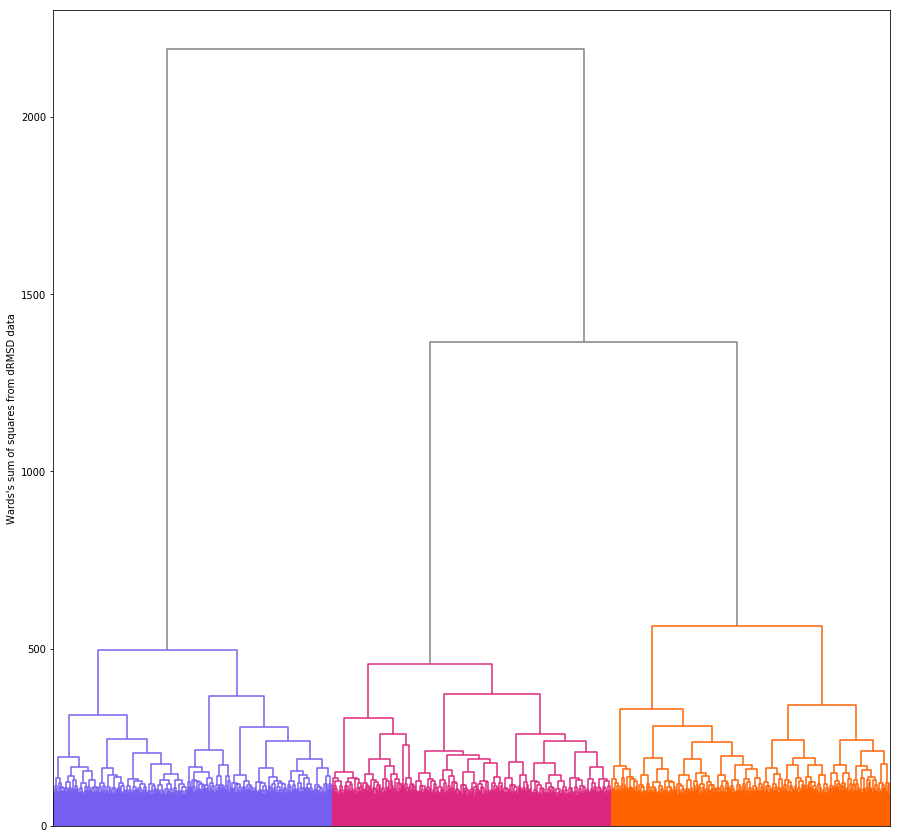

In [9]:
for regi in sorted(regiones):
    print regi
    
    plotting.modelDistanceDendo(outdata, regi, index, orderCell, 
                          colorsList, outplot, saveFig)